<a href="https://colab.research.google.com/github/Sarah0711/CUDA-Vision-Lab/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Modules

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp
import time
import copy
import os



#Check For GPU

In [ ]:
if torch.cuda.is_available:
  avDev = torch.device("cuda")
else:
  avDev = torch.device("cpu")
print(avDev)

cuda


#Set Seed

In [ ]:
seed = 1
torch.manual_seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True

#Utility for Displaying Images, Error Curve 

In [ ]:
def show_images(img,labels):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [ ]:
def plot_error_curve(errors):
  plt.suptitle('Learning Curve', fontsize=20)
  plt.xlabel('Iterations', fontsize=18)
  plt.ylabel('Classification Error', fontsize=16)
  plt.plot(np.array(errors))

#Load Data

In [ ]:
transform = transforms.Compose([      
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) 
test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

train_dataset = dsets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = dsets.CIFAR10('./data', train=False, download=True, transform=test_transform)
dataset_sizes = {'train':len(train_dataset), 'val':len(test_dataset)}

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 64
max_epochs = 25

#Make Data Iterable

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


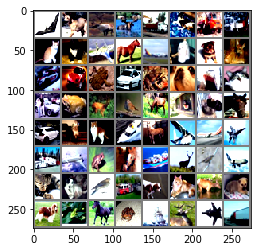

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

dataloaders = {'train':train_loader, 'val':test_loader}
dataiter = train_loader.__iter__()
images, labels = dataiter.next()
input_shape = images.shape
show_images(torchvision.utils.make_grid(images),labels)

#Model Definition

In [ ]:
# Encoder 
# torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                 stride=1, padding=0, dilation=1,
#                 groups=1, bias=True)
# batch x 3 x 32 x 32 -> batch x 512

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,32,3,padding=1),   
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1), 
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        # nn.Conv2d(64,64,3,padding=1),  
                        # nn.ReLU(),
                        # nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1), 
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        # nn.Conv2d(128,128,3,padding=1), 
                        # nn.ReLU(),
                        # nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 128 x 8 x 8
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.shape[0], -1)
        return out
encoder = Encoder().cuda()


In [ ]:
# Decoder 
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
#                          stride=1, padding=0, output_padding=0,
#                          groups=1, bias=True)
# output_height = (height-1)*stride + kernel_size - 2*(padding + output_padding)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        # nn.ConvTranspose2d(64,64,3,1,1),
                        # nn.ReLU(),
                        # nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(x.shape[0],256,8,8)
        # out = x
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()

In [ ]:
# Check output of autoencoder

for image,label in train_loader:
    image = image.cuda()
    
    output = encoder(image)
    output = decoder(output)
    break




#Train The Model

In [ ]:
def train_model(encoder, decoder, criterion, optimizer, noise=False, additive=0.25, multiplicative=0.1, num_epochs=25):
    since = time.time()

    best_encoder_wts = copy.deepcopy(encoder.state_dict())
    best_decoder_wts = copy.deepcopy(decoder.state_dict())
    best_acc = 0.0
    best_loss = np.inf
    number_of_epoch_stop = 10
    epochs_no_improve = 0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:

            if phase == 'train':
                encoder.train()  # Set model to training mode
                decoder.train()
            else:
                encoder.eval()   # Set model to evaluate mode
                decoder.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, _ in dataloaders[phase]:
  
                if noise:
                    inputs = torch.mul(inputs+additive, multiplicative * torch.rand(inputs.shape))

                inputs = inputs.to(avDev)
                    
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = encoder(inputs)
                    outputs = decoder(outputs)
                    loss = criterion(outputs, inputs)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_encoder_wts = copy.deepcopy(encoder.state_dict())
                    best_decoder_wts = copy.deepcopy(decoder.state_dict())
                    epochs_no_improve = 0

                else:
                    epochs_no_improve += 1
        print()

        if epochs_no_improve == number_of_epoch_stop:
          print('Early stopping!')
          break        


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    encoder.load_state_dict(best_encoder_wts)
    decoder.load_state_dict(best_decoder_wts)
    return encoder,decoder,best_loss

In [ ]:

def hp_train(args):
  

  optimizer = args[0]
  criterion = args[1]
  noise = args[2]

  print("Chosen Optimizer:", optimizer)
  print("Chosen Criterion:", criterion)
  print("Chosen Noise:", noise)

  encoder = Encoder().to(avDev)
  decoder = Decoder().to(avDev)


  learning_rate = 0.001
  parameters = list(encoder.parameters())+ list(decoder.parameters())

  optimizer = optimizer(parameters, lr=learning_rate)
  _,_,loss = train_model(encoder=encoder, decoder=decoder, criterion=criterion, optimizer=optimizer, noise=noise, num_epochs=max_epochs)
  return loss
    

#Define Space For Hyperopt

In [ ]:
optimizers = [torch.optim.SGD,torch.optim.Adam]
criterions = [nn.MSELoss()]
noisey = [False,True]

space = [hp.choice('Optimizers',optimizers),hp.choice('Criterions',criterions),hp.choice('Noisey',noisey)]

In [ ]:
best_classifier = fmin(hp_train,space,algo=tpe.suggest,max_evals=4,show_progressbar=False)
optimizer = optimizers[(best_classifier['Optimizers'])]
criterion = criterions[(best_classifier['Criterions'])]
noise = noisey[(best_classifier['Noisey'])]

Chosen Optimizer:
<class 'torch.optim.adam.Adam'>
Chosen Criterion:
MSELoss()
Chosen Noise:
True
Epoch 0/24
----------
train Loss: 0.0049
val Loss: 0.0022
Epoch 1/24
----------
train Loss: 0.0020
val Loss: 0.0020
Epoch 2/24
----------
train Loss: 0.0019
val Loss: 0.0019
Epoch 3/24
----------
train Loss: 0.0019
val Loss: 0.0020
Epoch 4/24
----------
train Loss: 0.0018
val Loss: 0.0019
Epoch 5/24
----------
train Loss: 0.0018
val Loss: 0.0020
Epoch 6/24
----------
train Loss: 0.0018
val Loss: 0.0017
Epoch 7/24
----------
train Loss: 0.0017
val Loss: 0.0017
Epoch 8/24
----------
train Loss: 0.0016
val Loss: 0.0015
Epoch 9/24
----------
train Loss: 0.0015
val Loss: 0.0015
Epoch 10/24
----------
train Loss: 0.0015
val Loss: 0.0019
Epoch 11/24
----------
train Loss: 0.0015
val Loss: 0.0017
Epoch 12/24
----------
train Loss: 0.0015
val Loss: 0.0015
Epoch 13/24
----------
train Loss: 0.0015
val Loss: 0.0014
Epoch 14/24
----------
train Loss: 0.0015
val Loss: 0.0014
Epoch 15/24
----------
train

In [ ]:
encoder = Encoder().to(avDev)
decoder = Decoder().to(avDev)


learning_rate = 0.001
parameters = list(encoder.parameters())+ list(decoder.parameters())

optimizer = optimizer(parameters, lr=learning_rate)
encoder,decoder,_ = train_model(encoder=encoder, decoder=decoder, criterion=criterion, optimizer=optimizer, noise=noise, num_epochs=max_epochs)


Epoch 0/24
----------
train Loss: 0.0056
val Loss: 0.0022

Epoch 1/24
----------
train Loss: 0.0021
val Loss: 0.0020

Epoch 2/24
----------
train Loss: 0.0019
val Loss: 0.0019

Epoch 3/24
----------
train Loss: 0.0018
val Loss: 0.0018

Epoch 4/24
----------
train Loss: 0.0018
val Loss: 0.0018

Epoch 5/24
----------
train Loss: 0.0017
val Loss: 0.0017

Epoch 6/24
----------
train Loss: 0.0017
val Loss: 0.0017

Epoch 7/24
----------
train Loss: 0.0017
val Loss: 0.0016

Epoch 8/24
----------
train Loss: 0.0016
val Loss: 0.0016

Epoch 9/24
----------
train Loss: 0.0016
val Loss: 0.0016

Epoch 10/24
----------
train Loss: 0.0016
val Loss: 0.0016

Epoch 11/24
----------
train Loss: 0.0015
val Loss: 0.0015

Epoch 12/24
----------
train Loss: 0.0015
val Loss: 0.0015

Epoch 13/24
----------
train Loss: 0.0014
val Loss: 0.0014

Epoch 14/24
----------
train Loss: 0.0014
val Loss: 0.0014

Epoch 15/24
----------
train Loss: 0.0014
val Loss: 0.0014

Epoch 16/24
----------
train Loss: 0.0014
val Loss

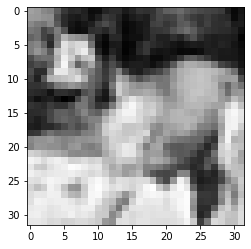

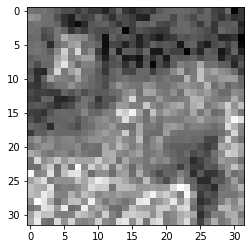

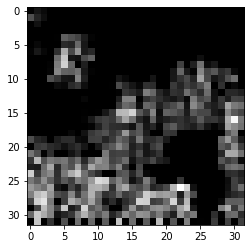

tensor(6)


In [ ]:
# check image with noise and denoised image\n# Better image if you train more or upgrade the model\n

input_imgs = torch.mul(images+0.25, 0.1 * torch.rand(images.shape)).cuda()

output_imgs = encoder(input_imgs)
output_imgs = decoder(output_imgs)

i = 1
img = images[i].cpu()
input_img = input_imgs[i].cpu()
output_img = output_imgs[i].cpu()


origin = img.numpy()
inp = input_img.numpy()
out = output_img.detach().numpy()

plt.imshow(origin[0],cmap='gray')
plt.show()

plt.imshow(inp[0],cmap='gray')
plt.show()

plt.imshow(out[0],cmap="gray")
plt.show()

print(label[0])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(avDev)
                labels = labels.to(avDev)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()


                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
from torch.optim import lr_scheduler

model = nn.Sequential(encoder,nn.Linear(256*8*8, 2048),nn.Linear(2048, 10))
model.to(avDev)


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 2.1051 Acc: 0.2446
val Loss: 2.0970 Acc: 0.2494

Epoch 1/24
----------
train Loss: 2.1023 Acc: 0.2451
val Loss: 2.0963 Acc: 0.2486

Epoch 2/24
----------
train Loss: 2.1020 Acc: 0.2469
val Loss: 2.0961 Acc: 0.2482

Epoch 3/24
----------
train Loss: 2.1031 Acc: 0.2458
val Loss: 2.0967 Acc: 0.2488

Epoch 4/24
----------
train Loss: 2.1024 Acc: 0.2450
val Loss: 2.0973 Acc: 0.2481

Epoch 5/24
----------
train Loss: 2.1014 Acc: 0.2458
val Loss: 2.0961 Acc: 0.2491

Epoch 6/24
----------
train Loss: 2.1006 Acc: 0.2457
val Loss: 2.0958 Acc: 0.2509

Epoch 7/24
----------
train Loss: 2.1030 Acc: 0.2442
val Loss: 2.0965 Acc: 0.2502

Epoch 8/24
----------
train Loss: 2.1026 Acc: 0.2445
val Loss: 2.0971 Acc: 0.2486

Epoch 9/24
----------
train Loss: 2.1020 Acc: 0.2453
val Loss: 2.0967 Acc: 0.2484

Epoch 10/24
----------
train Loss: 2.1022 Acc: 0.2461
val Loss: 2.0988 Acc: 0.2471

Epoch 11/24
----------
train Loss: 2.1021 Acc: 0.2448
val Loss: 2.0946 Acc: 0.2501

Ep

#Adam Optimizer

In [ ]:
class AdamOptimizer:
    def __init__(self, weights, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = 0
        self.v = 0
        self.t = 0
        self.theta = weights

    def backward_pass(self, gradient):
        self.t = self.t + 1
        self.m = self.beta1*self.m + (1 - self.beta1)*gradient
        self.v = self.beta2*self.v + (1 - self.beta2)*(gradient**2)
        m_hat = self.m/(1 - self.beta1**self.t)
        v_hat = self.v/(1 - self.beta2**self.t)
        self.theta = self.theta - self.alpha*(m_hat/(np.sqrt(v_hat) - self.epsilon))
        return self.theta

In [ ]:
import math
import torch
from torch.optim.optimizer import Optimizer


class Adam(Optimizer):
   


    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

In [ ]:

def train_model(model, criterion,  scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(avDev)
                labels = labels.to(avDev)

                # zero the parameter gradients

                

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer_adam.step()
                        scheduler.step()
                        

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
from torch.optim import lr_scheduler
model = nn.Sequential(encoder,nn.Linear(256*8*8, 2048),nn.Linear(2048, 10))
model.to(avDev)


criterion = nn.CrossEntropyLoss()


optimizer_adam =Adam(model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_adam, step_size=7, gamma=0.1)

model = train_model(model, criterion, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4873 Acc: 0.0861
val Loss: 2.4876 Acc: 0.0896

Epoch 1/24
----------
train Loss: 2.4859 Acc: 0.0865
val Loss: 2.4859 Acc: 0.0884

Epoch 2/24
----------
train Loss: 2.4870 Acc: 0.0866
val Loss: 2.4855 Acc: 0.0881

Epoch 3/24
----------
train Loss: 2.4869 Acc: 0.0857
val Loss: 2.4850 Acc: 0.0885

Epoch 4/24
----------
train Loss: 2.4859 Acc: 0.0878
val Loss: 2.4915 Acc: 0.0888

Epoch 5/24
----------
train Loss: 2.4862 Acc: 0.0863
val Loss: 2.4896 Acc: 0.0883

Epoch 6/24
----------
train Loss: 2.4875 Acc: 0.0854
val Loss: 2.4885 Acc: 0.0890

Epoch 7/24
----------
train Loss: 2.4851 Acc: 0.0865
val Loss: 2.4855 Acc: 0.0895

Epoch 8/24
----------
train Loss: 2.4881 Acc: 0.0856
val Loss: 2.4888 Acc: 0.0890

Epoch 9/24
----------
train Loss: 2.4868 Acc: 0.0862
val Loss: 2.4931 Acc: 0.0890

Epoch 10/24
----------
train Loss: 2.4860 Acc: 0.0870
val Loss: 2.4832 Acc: 0.0888

Epoch 11/24
----------
train Loss: 2.4860 Acc: 0.0871
val Loss: 2.4909 Acc: 0.0890

Ep